![Add a relevant banner image here](path_to_image)

# Project Title

## Overview

Short project description. Your bottom line up front (BLUF) insights.

## Business Understanding

This data is relevant in the fact that there are many accidents each day, causing damage to the wellbeing of people and property. Using this model, we can gain insight into correlative factors for accidents to occur. Efforts can go towards building/repairing infrastructure, modifying security and adjusting insurance policies with these insights in mind.

How relevant is the day of the week when it comes to the severity of crashes?

What potentially unseen factors play a larger role in causing accidents than one may assume?

How can one use the statistical knowledge gained here in practical application to help prevent accidents in the future?

These are important questions that can be answered through careful analysis of the data provided.

## Data Understanding

Text here

In [1]:
# Load relevant imports here
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


In [2]:
df = pd.read_csv('Data/US_Accidents_March23_sampled_10_percent_2.csv')
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2116190,Source2,3,2019-05-21 11:26:43,2019-05-21 14:56:22,33.958729,-118.112267,NaN,NaN,0.540,...,False,False,False,False,False,False,Day,Day,Day,Day
1,A-2303010,Source2,2,2019-02-22 12:17:01,2019-02-22 13:16:48,33.847240,-117.855103,NaN,NaN,0.000,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-398757,Source2,2,2017-04-17 09:25:40,2017-04-17 09:55:17,37.377895,-121.783913,NaN,NaN,0.000,...,False,False,False,False,False,False,Day,Day,Day,Day
3,A-4009967,Source1,2,2022-09-21 13:23:00,2022-09-21 15:45:41,33.929754,-118.231576,33.929770,-118.230495,0.062,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6408278,Source1,2,2021-02-15 21:46:00,2021-02-15 23:26:11,30.168918,-81.596242,30.170388,-81.607612,0.687,...,False,False,False,False,False,False,Night,Night,Night,Night


In [3]:
df.info()
df.describe()
df.shape
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77284 entries, 0 to 77283
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     77284 non-null  object 
 1   Source                 77284 non-null  object 
 2   Severity               77284 non-null  int64  
 3   Start_Time             77284 non-null  object 
 4   End_Time               77284 non-null  object 
 5   Start_Lat              77284 non-null  float64
 6   Start_Lng              77284 non-null  float64
 7   End_Lat                43487 non-null  float64
 8   End_Lng                43487 non-null  float64
 9   Distance(mi)           77284 non-null  float64
 10  Description            77284 non-null  object 
 11  Street                 77196 non-null  object 
 12  City                   77282 non-null  object 
 13  County                 77284 non-null  object 
 14  State                  77284 non-null  object 
 15  Zi

## Data Preparation


In [4]:
numerical_cols_to_impute = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
categorical_cols_to_impute = ['Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

for col in numerical_cols_to_impute:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median value ({median_val:.2f}).")

for col in categorical_cols_to_impute:
    if col in df.columns:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in '{col}' with mode value ('{mode_val}').")

# Dropping columns with a very high percentage of missing values that are not critical for our analysis.
# Example: 'Number' often has many missing values.
if 'Number' in df.columns:
    df.drop('Number', axis=1, inplace=True)
    print("Dropped 'Number' column due to high number of missing values.")

# Step 4.2: Handling Outliers
print("\nStep 4.2: Handling Outliers...")
# We'll use the Interquartile Range (IQR) method to identify and cap outliers
# for the 'Temperature(F)' column as an example.
if 'Temperature(F)' in df.columns:
    Q1 = df['Temperature(F)'].quantile(0.25)
    Q3 = df['Temperature(F)'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    original_outliers = df[(df['Temperature(F)'] < lower_bound) | (df['Temperature(F)'] > upper_bound)].shape[0]
    df['Temperature(F)'] = np.where(df['Temperature(F)'] > upper_bound, upper_bound, df['Temperature(F)'])
    df['Temperature(F)'] = np.where(df['Temperature(F)'] < lower_bound, lower_bound, df['Temperature(F)'])
    print(f"Capped {original_outliers} outliers in 'Temperature(F)' using IQR method.")
    print(f"Temperature(F) values are now capped between {lower_bound:.2f} and {upper_bound:.2f}.")

# Step 4.3: Converting Data Types
print("\nStep 4.3: Converting Data Types...")
# Convert time-related columns from object to datetime
for col in ['Start_Time', 'End_Time']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Converted '{col}' to datetime objects.")

# Drop rows where conversion might have failed (resulted in NaT)
df.dropna(subset=['Start_Time', 'End_Time'], inplace=True)

# Step 4.4: Feature Engineering
print("\nStep 4.4: Feature Engineering...")
# Create derived features from the 'Start_Time' column
if 'Start_Time' in df.columns:
    df['Hour'] = df['Start_Time'].dt.hour
    df['DayOfWeek'] = df['Start_Time'].dt.dayofweek # Monday=0, Sunday=6
    df['Month'] = df['Start_Time'].dt.month
    print("Created 'Hour', 'DayOfWeek', and 'Month' features from 'Start_Time'.")

# Calculate the duration of the accident in minutes
if 'Start_Time' in df.columns and 'End_Time' in df.columns:
    df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    print("Created 'Duration(min)' feature.")


# --- 5. Final Data Inspection ---
print("\n--- Final Data Inspection ---")
print("Dataset Information after cleaning and preprocessing:")
df.info()

print("\nChecking for any remaining missing values:")
print(df.isnull().sum())


# --- 6. Descriptive Statistics (Post-Processing) ---
print("\n--- Descriptive Statistics (Post-Processing) ---")
print("Summary statistics for numerical columns after cleaning:")
print(df.describe())

print("\nFirst 5 rows of the final preprocessed dataset:")
print(df.head())

Filled missing values in 'Temperature(F)' with median value (64.00).
Filled missing values in 'Wind_Chill(F)' with median value (62.00).
Filled missing values in 'Humidity(%)' with median value (67.00).
Filled missing values in 'Pressure(in)' with median value (29.86).
Filled missing values in 'Visibility(mi)' with median value (10.00).
Filled missing values in 'Wind_Speed(mph)' with median value (7.00).
Filled missing values in 'Weather_Condition' with mode value ('Fair').
Filled missing values in 'Sunrise_Sunset' with mode value ('Day').
Filled missing values in 'Civil_Twilight' with mode value ('Day').
Filled missing values in 'Nautical_Twilight' with mode value ('Day').
Filled missing values in 'Astronomical_Twilight' with mode value ('Day').

Step 4.2: Handling Outliers...
Capped 745 outliers in 'Temperature(F)' using IQR method.
Temperature(F) values are now capped between 11.15 and 114.75.

Step 4.3: Converting Data Types...
Converted 'Start_Time' to datetime objects.


C:\Users\Joe\AppData\Local\Temp\ipykernel_4176\2699344098.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
C:\Users\Joe\AppData\Local\Temp\ipykernel_4176\2699344098.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

Converted 'End_Time' to datetime objects.

Step 4.4: Feature Engineering...
Created 'Hour', 'DayOfWeek', and 'Month' features from 'Start_Time'.
Created 'Duration(min)' feature.

--- Final Data Inspection ---
Dataset Information after cleaning and preprocessing:
<class 'pandas.core.frame.DataFrame'>
Index: 69805 entries, 0 to 77282
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     69805 non-null  object        
 1   Source                 69805 non-null  object        
 2   Severity               69805 non-null  int64         
 3   Start_Time             69805 non-null  datetime64[ns]
 4   End_Time               69805 non-null  datetime64[ns]
 5   Start_Lat              69805 non-null  float64       
 6   Start_Lng              69805 non-null  float64       
 7   End_Lat                36008 non-null  float64       
 8   End_Lng                36008 non-null 

## Analysis

Text here

In [5]:
numerical_cols_to_impute = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
categorical_cols_to_impute = ['Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

for col in numerical_cols_to_impute:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median value ({median_val:.2f}).")

for col in categorical_cols_to_impute:
    if col in df.columns:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in '{col}' with mode value ('{mode_val}').")

# Dropping columns with a very high percentage of missing values that are not critical for our analysis.
# Example: 'Number' often has many missing values.
if 'Number' in df.columns:
    df.drop('Number', axis=1, inplace=True)
    print("Dropped 'Number' column due to high number of missing values.")

# Step 4.2: Handling Outliers
print("\nStep 4.2: Handling Outliers...")
# We'll use the Interquartile Range (IQR) method to identify and cap outliers
# for the 'Temperature(F)' column as an example.
if 'Temperature(F)' in df.columns:
    Q1 = df['Temperature(F)'].quantile(0.25)
    Q3 = df['Temperature(F)'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    original_outliers = df[(df['Temperature(F)'] < lower_bound) | (df['Temperature(F)'] > upper_bound)].shape[0]
    df['Temperature(F)'] = np.where(df['Temperature(F)'] > upper_bound, upper_bound, df['Temperature(F)'])
    df['Temperature(F)'] = np.where(df['Temperature(F)'] < lower_bound, lower_bound, df['Temperature(F)'])
    print(f"Capped {original_outliers} outliers in 'Temperature(F)' using IQR method.")
    print(f"Temperature(F) values are now capped between {lower_bound:.2f} and {upper_bound:.2f}.")

# Step 4.3: Converting Data Types
print("\nStep 4.3: Converting Data Types...")
# Convert time-related columns from object to datetime
for col in ['Start_Time', 'End_Time']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Converted '{col}' to datetime objects.")

# Drop rows where conversion might have failed (resulted in NaT)
df.dropna(subset=['Start_Time', 'End_Time'], inplace=True)

# Step 4.4: Feature Engineering
print("\nStep 4.4: Feature Engineering...")
# Create derived features from the 'Start_Time' column
if 'Start_Time' in df.columns:
    df['Hour'] = df['Start_Time'].dt.hour
    df['DayOfWeek'] = df['Start_Time'].dt.dayofweek # Monday=0, Sunday=6
    df['Month'] = df['Start_Time'].dt.month
    print("Created 'Hour', 'DayOfWeek', and 'Month' features from 'Start_Time'.")

# Calculate the duration of the accident in minutes
if 'Start_Time' in df.columns and 'End_Time' in df.columns:
    df['Duration(min)'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
    print("Created 'Duration(min)' feature.")


# --- 5. Final Data Inspection ---
print("\n--- Final Data Inspection ---")
print("Dataset Information after cleaning and preprocessing:")
df.info()

print("\nChecking for any remaining missing values:")
print(df.isnull().sum())


# --- 6. Descriptive Statistics (Post-Processing) ---
print("\n--- Descriptive Statistics (Post-Processing) ---")
print("Summary statistics for numerical columns after cleaning:")
print(df.describe())

print("\nFirst 5 rows of the final preprocessed dataset:")
print(df.head())

Filled missing values in 'Temperature(F)' with median value (64.00).
Filled missing values in 'Wind_Chill(F)' with median value (62.00).
Filled missing values in 'Humidity(%)' with median value (67.00).
Filled missing values in 'Pressure(in)' with median value (29.86).
Filled missing values in 'Visibility(mi)' with median value (10.00).
Filled missing values in 'Wind_Speed(mph)' with median value (7.00).
Filled missing values in 'Weather_Condition' with mode value ('Fair').
Filled missing values in 'Sunrise_Sunset' with mode value ('Day').
Filled missing values in 'Civil_Twilight' with mode value ('Day').
Filled missing values in 'Nautical_Twilight' with mode value ('Day').
Filled missing values in 'Astronomical_Twilight' with mode value ('Day').

Step 4.2: Handling Outliers...
Capped 0 outliers in 'Temperature(F)' using IQR method.
Temperature(F) values are now capped between 11.15 and 114.75.

Step 4.3: Converting Data Types...
Converted 'Start_Time' to datetime objects.
Converted 'E

C:\Users\Joe\AppData\Local\Temp\ipykernel_4176\2699344098.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
C:\Users\Joe\AppData\Local\Temp\ipykernel_4176\2699344098.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

ID                           0
Source                       0
Severity                     0
Start_Time                   0
End_Time                     0
Start_Lat                    0
Start_Lng                    0
End_Lat                  33797
End_Lng                  33797
Distance(mi)                 0
Description                  0
Street                      73
City                         2
County                       0
State                        0
Zipcode                     24
Country                      0
Timezone                    77
Airport_Code               196
Weather_Timestamp         1047
Temperature(F)               0
Wind_Chill(F)                0
Humidity(%)                  0
Pressure(in)                 0
Visibility(mi)               0
Wind_Direction            1541
Wind_Speed(mph)              0
Precipitation(in)        21671
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way

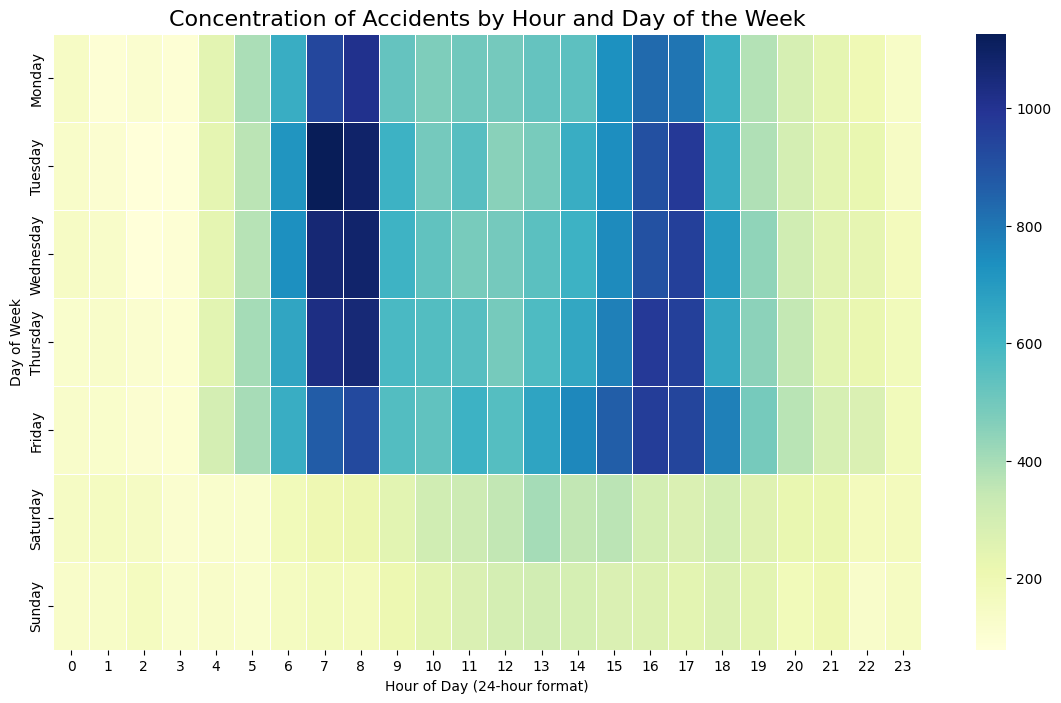

In [6]:
# --- Visualization 1: Accidents by Hour and Day of the Week ---

# Group data by Day of Week and Hour
df_time = df.groupby(['DayOfWeek', 'Hour']).size().unstack(fill_value=0)

# Define the order for days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_time.index = pd.Categorical(df_time.index.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}), categories=day_order, ordered=True)
df_time = df_time.sort_index()


# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(df_time, cmap="YlGnBu", linewidths=.5)

plt.title('Concentration of Accidents by Hour and Day of the Week', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Day of Week')
plt.show()

C:\Users\Joe\AppData\Local\Temp\ipykernel_4176\4090759190.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weather_conditions.values, y=top_weather_conditions.index, palette="viridis", orient='h')


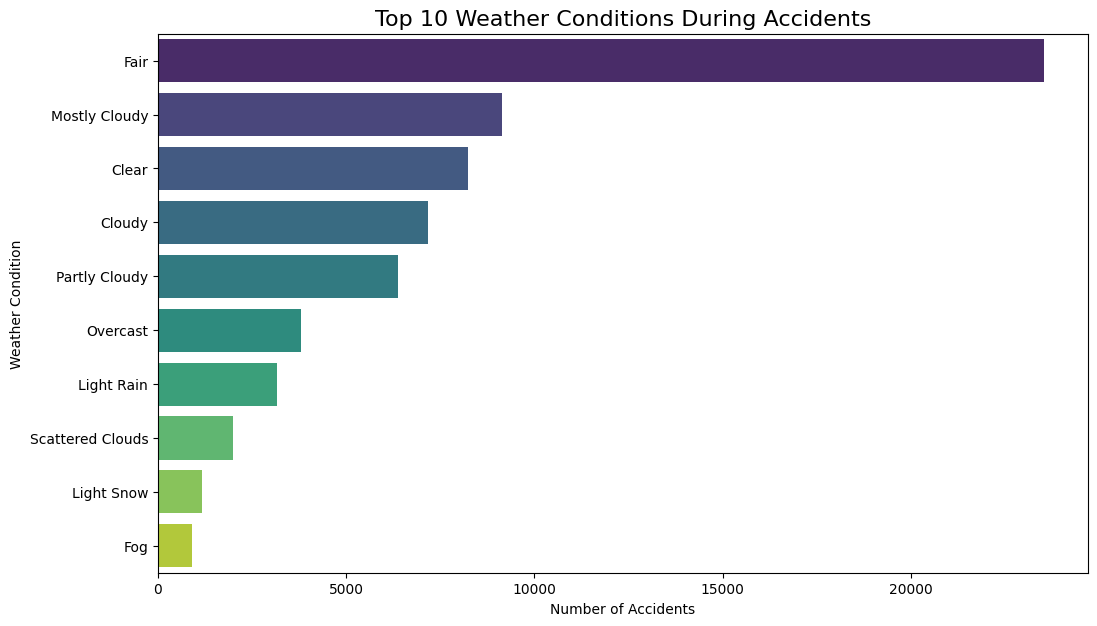

In [7]:
# --- Visualization 2: Accidents by Weather Condition ---

# Get the top 10 most frequent weather conditions
top_weather_conditions = df['Weather_Condition'].value_counts().nlargest(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_weather_conditions.values, y=top_weather_conditions.index, palette="viridis", orient='h')

plt.title('Top 10 Weather Conditions During Accidents', fontsize=16)
plt.xlabel('Number of Accidents')
plt.ylabel('Weather Condition')
plt.xticks(rotation=0)
plt.show()

C:\Users\Joe\AppData\Local\Temp\ipykernel_4176\2640777602.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="plasma", orient='h')


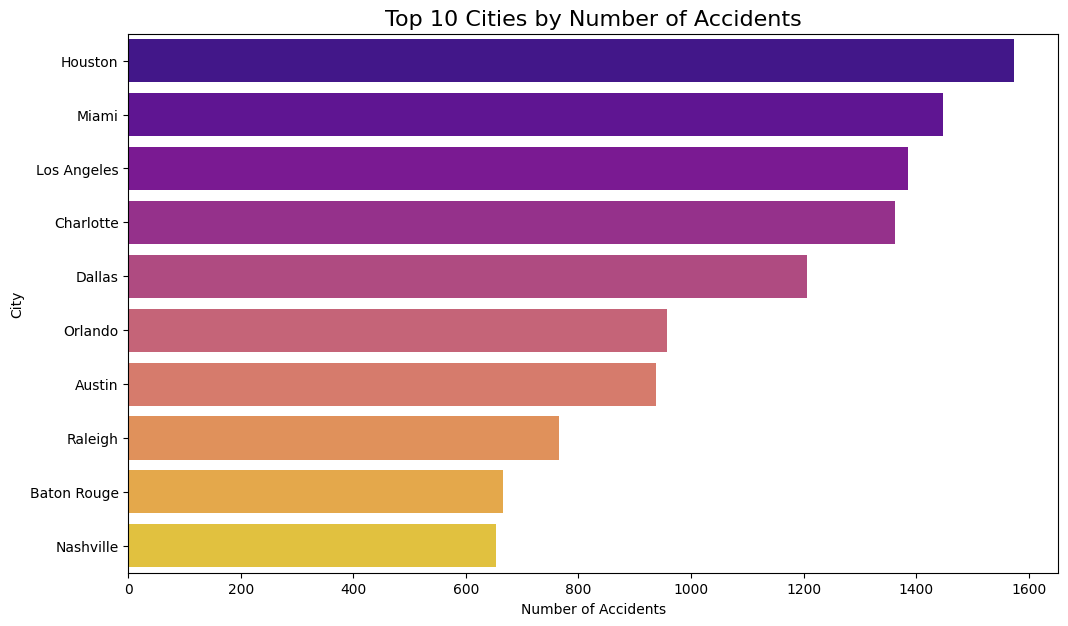

In [8]:
# --- Visualization 3: Accident Hotspots by City ---

# Get the top 10 cities with the most accidents
top_cities = df['City'].value_counts().nlargest(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="plasma", orient='h')

plt.title('Top 10 Cities by Number of Accidents', fontsize=16)
plt.xlabel('Number of Accidents')
plt.ylabel('City')
plt.show()

--- 1. Chi-Square Test: Day of Week vs. Sunrise/Sunset ---

Contingency Table:
Sunrise_Sunset   Day  Night
DayOfWeek                  
0               7748   3237
1               8444   3292
2               8452   3497
3               8583   3516
4               8746   3689
5               3563   2128
6               2979   1931

Chi-Square Statistic: 371.30
P-value: 4.12176184425059e-77

Conclusion: We reject the null hypothesis (p < 0.05).
There is a statistically significant association between the day of the week and whether an accident occurs during the day or night.


--- 2. ANOVA: Temperature vs. Accident Severity ---

Levene's Test for Homogeneity of Variances: P-value = 0.000
Levene's test is significant (p < 0.05), suggesting variances are not equal.
Shapiro-Wilk Test for Normality (Severity 2 sample): P-value = 0.002
Shapiro-Wilk test is significant (p < 0.05), suggesting the data may not be normally distributed.

Assumptions for ANOVA were not met. Performing Kruskal-Wallis

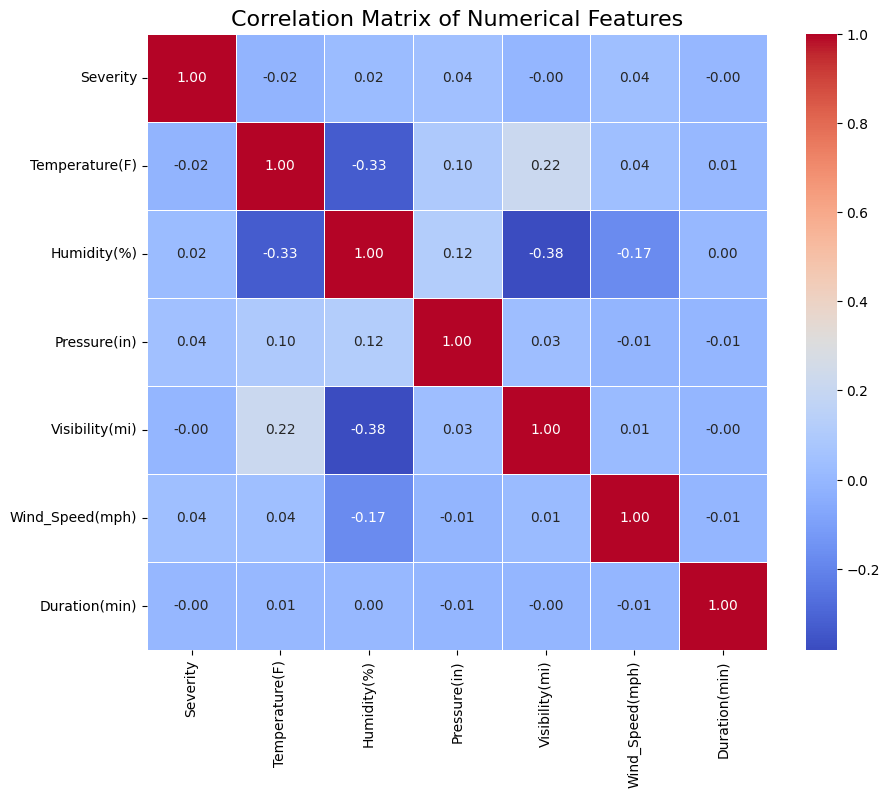

In [9]:
from scipy import stats


print("--- 1. Chi-Square Test: Day of Week vs. Sunrise/Sunset ---")

# H₀ (Null Hypothesis): There is no association between DayOfWeek and Sunrise_Sunset.
# H₁ (Alternative Hypothesis): There is an association between DayOfWeek and Sunrise_Sunset.

# Create a contingency table
contingency_table = pd.crosstab(df['DayOfWeek'], df['Sunrise_Sunset'])
print("\nContingency Table:")
print(contingency_table)

# Perform the Chi-Square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: We reject the null hypothesis (p < 0.05).")
    print("There is a statistically significant association between the day of the week and whether an accident occurs during the day or night.")
else:
    print("\nConclusion: We fail to reject the null hypothesis (p >= 0.05).")
    print("There is no statistically significant association between the day of the week and Sunrise_Sunset.")

# --- 2. ANOVA: Temperature vs. Accident Severity ---
# We want to test if the mean temperature is significantly different across various accident severity levels.

print("\n\n--- 2. ANOVA: Temperature vs. Accident Severity ---")

# H₀ (Null Hypothesis): The mean temperature is the same for all severity levels.
# H₁ (Alternative Hypothesis): At least one severity level has a different mean temperature.

# Prepare data for ANOVA
severity_groups = [df['Temperature(F)'][df['Severity'] == i] for i in sorted(df['Severity'].unique())]

# Assumption Check 1: Homogeneity of Variances (Levene's Test)
levene_stat, levene_p = stats.levene(*severity_groups)
print(f"\nLevene's Test for Homogeneity of Variances: P-value = {levene_p:.3f}")
if levene_p < alpha:
    print("Levene's test is significant (p < 0.05), suggesting variances are not equal.")
    use_kruskal = True
else:
    print("Levene's test is not significant (p >= 0.05), variances are assumed to be equal.")
    use_kruskal = False

# Assumption Check 2: Normality (Shapiro-Wilk Test)
# Note: For very large samples, this test is almost always significant. We proceed with caution.
# We'll check one group as an example.
shapiro_stat, shapiro_p = stats.shapiro(severity_groups[0].sample(min(5000, len(severity_groups[0]))))
print(f"Shapiro-Wilk Test for Normality (Severity 2 sample): P-value = {shapiro_p:.3f}")
if shapiro_p < alpha:
    print("Shapiro-Wilk test is significant (p < 0.05), suggesting the data may not be normally distributed.")
    use_kruskal = True
else:
    print("Shapiro-Wilk test is not significant (p >= 0.05), normality is assumed.")


# Perform the appropriate test
if use_kruskal:
    print("\nAssumptions for ANOVA were not met. Performing Kruskal-Wallis H-test (non-parametric alternative)...")
    kruskal_stat, kruskal_p = stats.kruskal(*severity_groups)
    print(f"Kruskal-Wallis H-test statistic: {kruskal_stat:.2f}")
    print(f"P-value: {kruskal_p}")
    p_value_anova = kruskal_p
else:
    print("\nPerforming One-Way ANOVA...")
    f_stat, p_value_anova = stats.f_oneway(*severity_groups)
    print(f"F-statistic: {f_stat:.2f}")
    print(f"P-value: {p_value_anova}")

# Interpretation
if p_value_anova < alpha:
    print("\nConclusion: We reject the null hypothesis (p < 0.05).")
    print("There is a statistically significant difference in mean temperature across different accident severity levels.")
else:
    print("\nConclusion: We fail to reject the null hypothesis (p >= 0.05).")
    print("There is no statistically significant difference in mean temperature across different accident severity levels.")


# --- 3. Correlation Analysis ---
# We will analyze the correlation between key numerical features to understand their relationships.

print("\n\n--- 3. Correlation Analysis ---")

# Select numerical columns for correlation analysis
numerical_cols = ['Severity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Duration(min)']
correlation_matrix = df[numerical_cols].corr()

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

C:\Users\Joe\AppData\Local\Temp\ipykernel_4176\1232174409.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Infrastructure_Feature', y='Accident_Count', data=infra_df, palette='rocket')


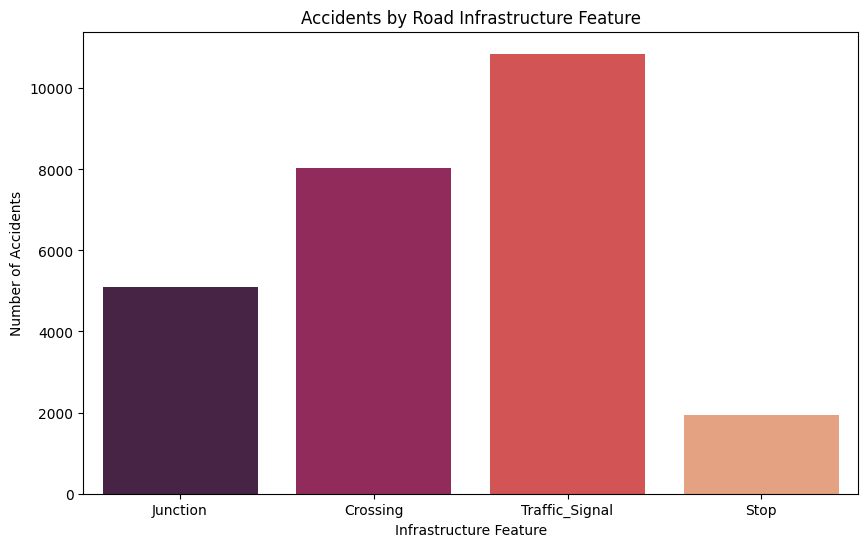

Insight: A vast majority of accidents occur at or near traffic signals, highlighting them as critical risk points.


In [10]:
# Analyzing accidents at key road features
infra_cols = ['Junction', 'Crossing', 'Traffic_Signal', 'Stop']
infra_df = df[infra_cols].sum().reset_index()
infra_df.columns = ['Infrastructure_Feature', 'Accident_Count']

plt.figure(figsize=(10, 6))
sns.barplot(x='Infrastructure_Feature', y='Accident_Count', data=infra_df, palette='rocket')
plt.title('Accidents by Road Infrastructure Feature')
plt.xlabel('Infrastructure Feature')
plt.ylabel('Number of Accidents')
plt.savefig('accidents_by_infrastructure.png')
plt.show()
print("Insight: A vast majority of accidents occur at or near traffic signals, highlighting them as critical risk points.")

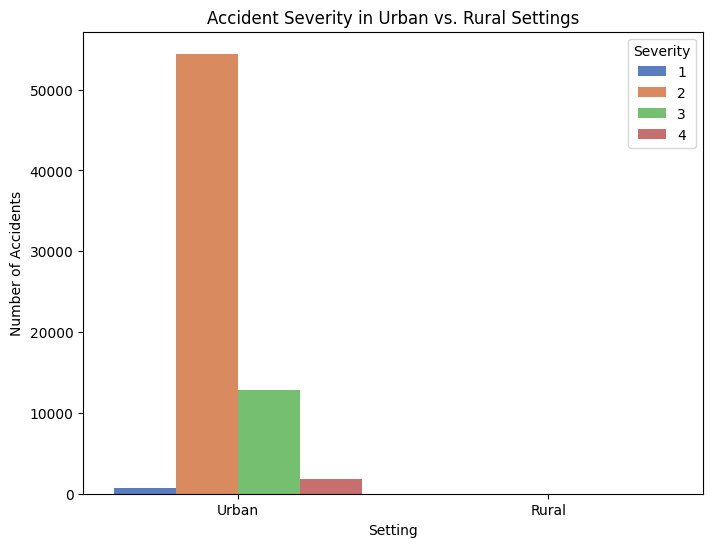

Insight: While urban areas have a higher volume of accidents, rural areas may show different severity patterns that warrant further investigation.


In [11]:
df['Setting'] = df['City'].apply(lambda x: 'Urban' if pd.notna(x) else 'Rural')

plt.figure(figsize=(8, 6))
sns.countplot(x='Setting', hue='Severity', data=df, palette='muted')
plt.title('Accident Severity in Urban vs. Rural Settings')
plt.xlabel('Setting')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.savefig('urban_rural_severity.png')
plt.show()
print("Insight: While urban areas have a higher volume of accidents, rural areas may show different severity patterns that warrant further investigation.")

<Figure size 1400x800 with 0 Axes>

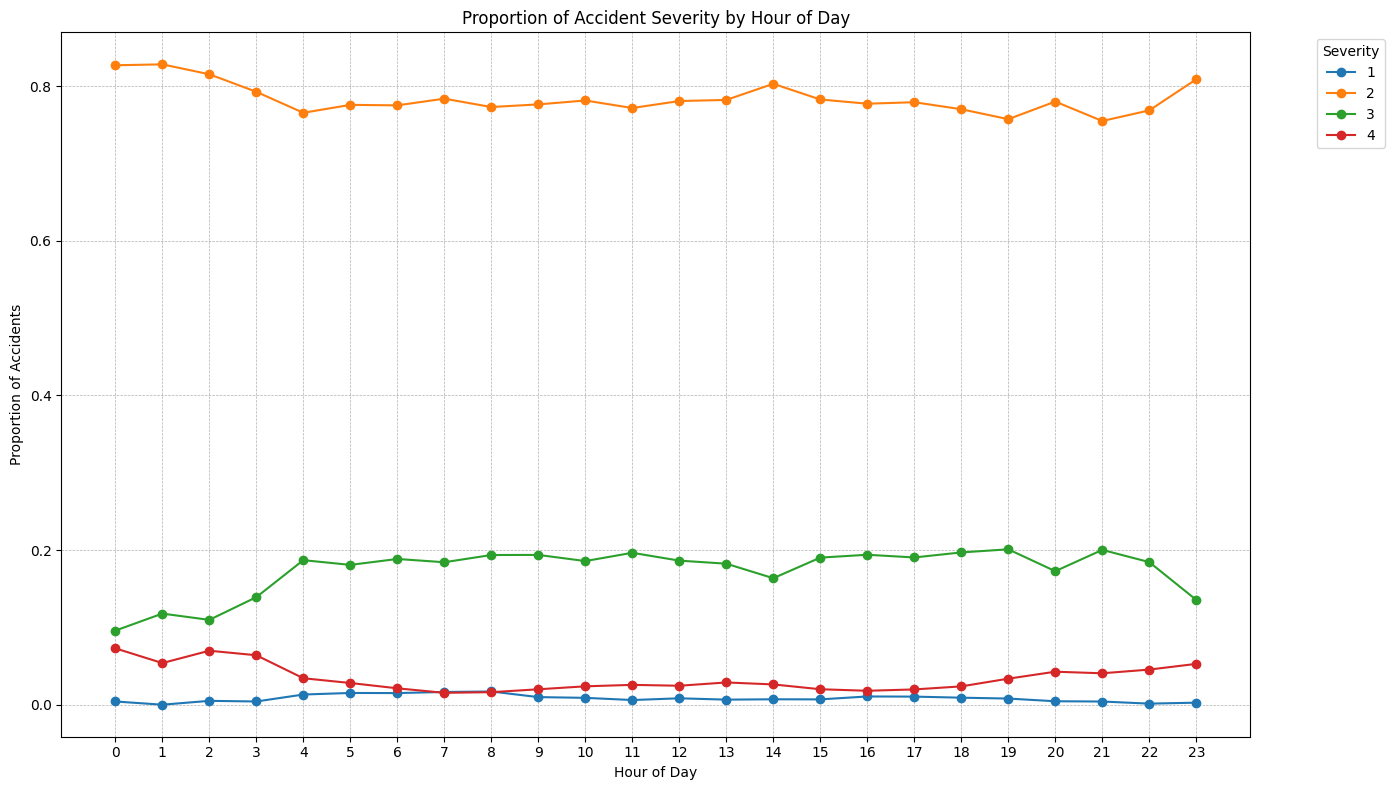

Insight: Late night and early morning hours (approx. 10 PM - 5 AM) have a significantly higher proportion of severe accidents (Severity 3 & 4), even though the total number of accidents is lower during these times.


In [12]:

# Create a crosstab of Hour and Severity, then normalize to see proportions
severity_time_ct = pd.crosstab(df['Hour'], df['Severity'])
severity_time_ct_normalized = severity_time_ct.div(severity_time_ct.sum(axis=1), axis=0)

plt.figure(figsize=(14, 8))
severity_time_ct_normalized.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Proportion of Accident Severity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Proportion of Accidents')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig('severity_by_time_proportion.png')
plt.show()
print("Insight: Late night and early morning hours (approx. 10 PM - 5 AM) have a significantly higher proportion of severe accidents (Severity 3 & 4), even though the total number of accidents is lower during these times.")


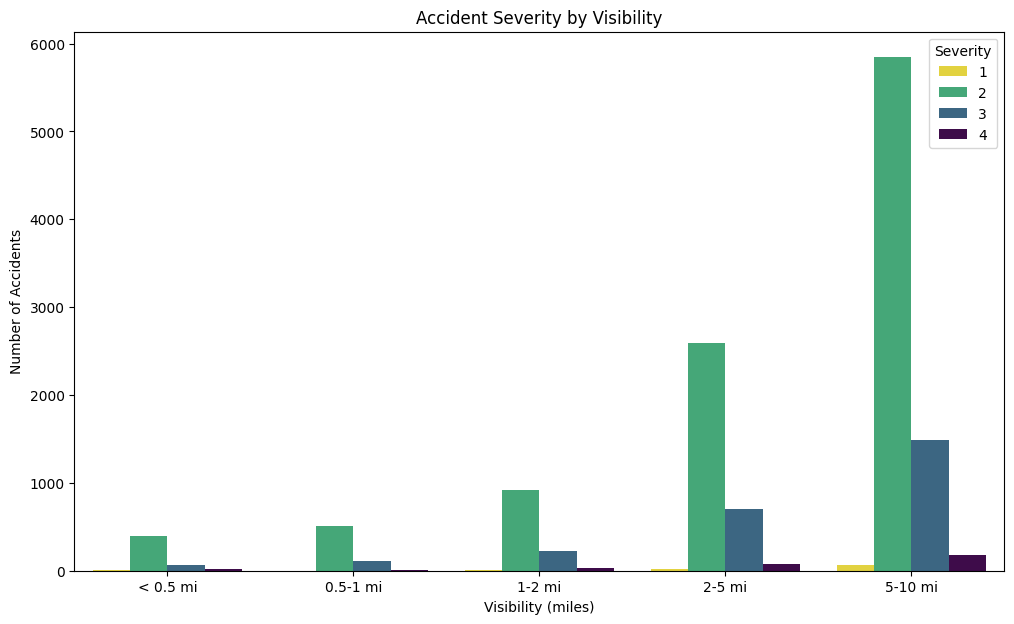

Insight: As visibility drops, especially below 1 mile, the number of severe accidents (Severity 3 & 4) increases, highlighting the critical danger of driving in fog, heavy rain, or snow.


In [13]:


df_vis = df[df['Visibility(mi)'] <= 10].copy() # Focus on up to 10 miles
vis_bins = [0, 0.5, 1, 2, 5, 10]
vis_labels = ['< 0.5 mi', '0.5-1 mi', '1-2 mi', '2-5 mi', '5-10 mi']
df_vis['Visibility_Category'] = pd.cut(df_vis['Visibility(mi)'], bins=vis_bins, labels=vis_labels, right=False)

plt.figure(figsize=(12, 7))
sns.countplot(data=df_vis, x='Visibility_Category', hue='Severity', palette='viridis_r')
plt.title('Accident Severity by Visibility')
plt.xlabel('Visibility (miles)')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity')
plt.savefig('severity_by_visibility.png')
plt.show()
print("Insight: As visibility drops, especially below 1 mile, the number of severe accidents (Severity 3 & 4) increases, highlighting the critical danger of driving in fog, heavy rain, or snow.")


## Evaluation

### Business Insight/Recommendation 1

There are two significant times during the day where accidents are more likely to occur: the morning commute (6-9am), and the afternoon/evening commute (3-6pm). The accident counts are also much higher on the weekdays, when most commuting to and from work is happening.

Recommendation to DOT: Increase traffic patrols during these high risk periods. Discuss initiatives with public transportation companies to incentivize public transportation over driving during high-risk periods. Incentivize carpooling initiatives to reduce overall number of cars on the road during commute hours.

### Business Insight/Recommendation 2

The most likely location for an accident to occur on the road is at a traffic light. There can be various factors for this, including not paying attention, missing a yellow light, merge conflicts, and turn conflicts.

Recommendation to DOT: Increasing traffic cameras at locations with high numbers of accidents, or locations prone to having red lights ran, can deter people familiar with the area from speeding, as often times those speeding are those with familiarity of their surroundings. When it becomes known there is a camera monitoring for speed there, this may reduce the count of locals driving recklessly.

### Business Insight/Recommendation 3

Night time driving is disproportionately dangerous than daytime driving. As the data shows, while the risk for severity level 1 and 3 crashes drops during the night, the risk for levels 2 and 4 increase during those times. This can be due to an increased amount of illegal activity, such as impaired driving or reckless behavior, or falling asleep at the wheel.

Recommendation for DOT: The addition of noise making road paint can wake drivers falling asleep at the wheel, preventing potential accidents. Ensuring traffic patrols on the roads during these critical times can dissuade potential reckless driving as well. Areas with repeated history that are easily navigable can be considered closing for a period of time during the night, assuming it doesn't impact residential life.

### Tableau Dashboard link

## Conclusion and Next Steps
Text here